
#                                                   The Empiral Interpolation Method (EIM)
 Script by Elise Grosjean (ENSTA-Paris, elise.grosjean@ensta-paris.fr)

In [70]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scikit-fem

The EIM build a linear combination of fully determined solutions from basis functions $(q_i)_{i=1,...,M}$ depending on some interpolating points (called "magic points") and some values $(\alpha_i)_{i=1,...,M}$ relying on certain instances of the parameter $\nu$, selected within the algorithm.                                                                                                                                                                      

Let us introduce the method with the following example:                                                                                                                                                                               
Consider a function                                                                                                                                                                                                                   
                                                                                                                                                                                                                                      
$$ g(x,\nu)= \frac1{\sqrt{(x_1-\nu_1)^2+(y_1-\nu_2)}},$$                                                                                                                                                                              
                                                                                                                                                                                                                         
with $x=(x_1,x_2)$ and $\nu=(\nu_1,\nu_2)$. 

- #### "OFFLINE"

The first chosen parameter $\nu^1$ is the one that maximizes $g$ on norm $\mathcal{L}^{\infty}$ (we want to retrieve most information on $g$ with few points) and the associated magic point $x^1$ is the point that gives the most information on $g(\\
\cdot,\nu^1)$ i.e. which maximizes its modulus.                                                                                                                                                                                        
Then the first basis function is                                                                                                                                                                                                      
$q_1(\cdot) = \frac{g(\cdot,\nu^1)}{g(x^1, \nu^1)}$.                                                                                                                                                                                  
We can then find $\alpha_1$ as the coefficient corresponding to this basis function:

We compute for each training parameters $\nu \in \mathcal{G}$ the real $G$ such that $G=g(x^1,\nu)$ and then we solve the problem $Q \alpha^1(\nu)=G$ where $Q$ at this initialization step is just $q_1(x^1)$.

Then, $M$ basis functions are constructed recursively with the following interpolation problem                                                                                                                                                                                                                                                                                                   
Find $\{\alpha_j^{M-1}(g)\}_{1\leq j \leq M}$ such that                                                                                                                                                                               
$$ \forall 1 \leq i \leq M-1,\  \mathcal{I}_{M-1}[g](x^i)= g(x^i),$$                                                                                                                                                                    
where the EIM operator is defined by                                                                                                                                                                                                    
 $$\mathcal{I}_{M-1}[g]=\sum_{j=1}^{M-1}  \alpha_j^{M-1} q_j.$$ 

- #### " ONLINE " 

Now we are interested  by a new parameter $\nu^{target}$.
We compute for $\nu^{target} \in \mathcal{G}$ the vector $G \in \mathbb{R}^M$ such that $G_i=g(x^i,\nu^{target})$ for $i=1,\dots,M$ and then we solve the problem $Q \alpha(\nu)=G$ where $Q \in \mathbb{R}^{M\times M}$ is such that $Q_{i,j}=q_j(x^i)$ for $i,j=1,\dots,M$ (where $q_j$ are our basis functions and $x^i$ our magic points.
The solution approximation is then given by
$$ g^M(x,\nu)=\sum_{i=1}^M \alpha(\nu) q(x). $$ 


In [2]:
# import packages
import skfem  # for Finite Element Method
import numpy as np
import matplotlib.pyplot as plt

<skfem MeshTri1 object>
  Number of elements: 512
  Number of vertices: 289
  Number of nodes: 289
  Named boundaries [# facets]: left [16], bottom [16], right [16], top [16], down [16], up [16]


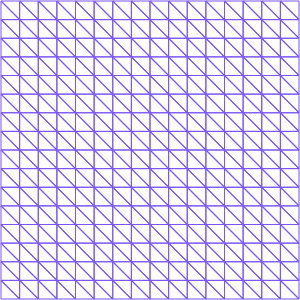

In [3]:
""" First we define a mesh for the unit square with the boundary decomposition """
mesh= skfem.MeshTri().refined(4).with_boundaries(
        {                                                                                                                                
            "left": lambda x: x[0] == 0,                                                                                            
            "right": lambda x: x[0] == 1,            
            "down": lambda x: x[1] == 0,                                                                                            
            "up": lambda x: x[1] == 1,     
            
        }                                                                                                                               
)

print(mesh)
mesh


In [4]:
from skfem import *

""" OFFLINE """
""" Initialization: M=1 ! """
# We seek mu* and x* s.t mu*=argmax_mu ||g(mu)||_inf and x*=argmax_x ||g(mu*)||_inf

NumberOfModes=15;#number of basis functions (a priori given)
NumberOfSnapshots=20;#training parameters number (ns*ns)

#real mu1,mu2;//parameter in [-1,-0.01]^2
g = lambda x: 1/np.sqrt((x[0]-mu[0])**2+(x[1]-mu[1])) #exact non-linear (wrt parameters) function

basis = Basis(mesh, ElementTriP0())  # here we consider P0 finite elements

#grid parameter repartition
MuBegin = -1.
MuEnd = -0.01

mu1=np.zeros(NumberOfSnapshots)
mu2=np.zeros(NumberOfSnapshots)
for i in range(NumberOfSnapshots):
    mu1[i]=MuBegin+i*np.abs(MuBegin-MuEnd)/(NumberOfSnapshots-1)
mu2=mu1.copy()

muGrid=np.meshgrid(mu1,mu2) #grid of parameters

GGrid=np.zeros((basis.doflocs.shape[1],NumberOfSnapshots*NumberOfSnapshots)) #function g evaluated for all degrees of freedom (doflocs) 
GinftyGrid=np.zeros(NumberOfSnapshots*NumberOfSnapshots) # L^infty norm of g

for i,elem1 in enumerate((list(mu1))):
    for j,elem2 in enumerate((list(mu2))):
        mu=[elem1,elem2] #update mu
        u=basis.project(g) #u is simply the projection onto the FEM basis of g with the parameter mu
        
        GGrid[:,i*NumberOfSnapshots+j]=u #g(mu)
        GinftyGrid[i*NumberOfSnapshots+j]=np.linalg.norm(u,np.inf) # norm_inf g(mu)

muIndex=np.argmax(GinftyGrid) 
muIndexlist=[muIndex]
mu1Index=int(np.floor(muIndex/NumberOfSnapshots))
mu2Index=int(muIndex-mu1Index*NumberOfSnapshots)

mu=[mu1[mu1Index],mu2[mu2Index]]
g1=basis.project(g) # find the mu* s.t argmax_mu ||g(mu)||_inf
XIndex=np.argmax(g1)

dof_locs = basis.doflocs
MagicPoint=[dof_locs[0][XIndex],dof_locs[1][XIndex]] #Find first magic point
print(" First magic point ", MagicPoint)

q1= g1/g1[XIndex] # First basis function !
qlist=[q1]

MagicPointlist=[MagicPoint]
MagicPointIndiceslist=[XIndex]

 First magic point  [0.03125, 0.03125]


The idea is to find the coefficients $\alpha$ such that 
$$ g(x^i,\nu)=\sum_{i=0}^{M-1} \alpha^j(\nu) q^j(x^i)$$
where $(q^j)_{j=0,\dots,M-1}$ are the basis functions already computed.

So for all parameters $\nu$, we find $\alpha(\nu)$ such that $Q \ \alpha = G$, where $Q_{i,j}=q^j(x^i)$ for $i,j=1,\dots,M$ and $G= g(x^i,\nu)$

In [5]:
### EIM offline iterations

for M in range(1,NumberOfModes):
    print("M: ",M)
    Qmat=np.zeros((M,M)) #Triangular matrix
    for k1 in range(M):
        for k2 in range(M):
            Qmat[k1,k2]=qlist[k2][MagicPointIndiceslist[k1]]
    
    GGrid=np.zeros((basis.doflocs.shape[1],NumberOfSnapshots*NumberOfSnapshots)) #function g evaluated for all degree of freedom (doflocs) 
    GinftyGrid=np.zeros(NumberOfSnapshots*NumberOfSnapshots)
    for i,elem1 in enumerate((list(mu1))):
        for j,elem2 in enumerate((list(mu2))):
            mu=[elem1,elem2]
            Gvec=np.zeros(M)
            u=basis.project(g)
            for k1 in range(M):
                Gvec[k1]=u[MagicPointIndiceslist[k1]]
            alpha=np.linalg.solve(Qmat,Gvec)
            
            for k1 in range(M):
                u-=alpha[k1]*qlist[k1] #g-I[G] (to find the new basis function we retrieve the previous ones)
            
            GGrid[:,i*NumberOfSnapshots+j]=u 
            GinftyGrid[i*NumberOfSnapshots+j]=np.linalg.norm(u,np.inf)

    for elem in muIndexlist: # if already in the list (we could have used a dictionnary instead)
        GinftyGrid[elem]=-1e30
        
    muIndex=np.argmax(GinftyGrid) #find the mu* s.t argmax_mu ||g(mu)-I[g(mu)]||_inf
    muIndexlist.append(muIndex)
    
    mu1Index=int(np.floor(muIndex/NumberOfSnapshots))
    mu2Index=int(muIndex-mu1Index*NumberOfSnapshots)

    mu=[mu1[mu1Index],mu2[mu2Index]]
    g1=GGrid[:,muIndex].copy()
   
    for elem in MagicPointIndiceslist:
        g1[elem]=-1e30 #magic point not selected if already in the list
    
    XIndex=np.argmax(g1) #Find associated magic point: x* s.t argmax_x ||g(mu*)-I[g(mu*)]||_inf
   
    MagicPoint=[dof_locs[0][XIndex],dof_locs[1][XIndex]]
    print(" New magic point ", MagicPoint)
    
    qM= GGrid[:,muIndex]/GGrid[XIndex,muIndex] # New basis 
    qlist.append(qM)
    
    MagicPointlist.append(MagicPoint)
    MagicPointIndiceslist.append(XIndex)

M:  1
 New magic point  [0.03125, 0.15625]
M:  2
 New magic point  [0.1875, 0.03125]
M:  3
 New magic point  [0.9375, 0.03125]
M:  4
 New magic point  [0.03125, 0.9375]
M:  5
 New magic point  [0.03125, 0.0625]
M:  6
 New magic point  [0.40625, 0.03125]
M:  7
 New magic point  [0.0625, 0.03125]
M:  8
 New magic point  [0.15625, 0.0625]
M:  9
 New magic point  [0.96875, 0.96875]
M:  10
 New magic point  [0.21875, 0.4375]
M:  11
 New magic point  [0.03125, 0.40625]
M:  12
 New magic point  [0.03125, 0.0625]
M:  13
 New magic point  [0.21875, 0.1875]
M:  14
 New magic point  [0.65625, 0.03125]


In [6]:
# ONLINE PART !!

mu=[-0.5,-0.5]; #New targeted parameter!!
u=basis.project(g)

sol=0
Qmat=np.zeros((NumberOfModes,NumberOfModes))
for k1 in range(NumberOfModes):
    for k2 in range(NumberOfModes):
        if k2<=k1:    #triangular matrix
            Qmat[k1,k2]=qlist[k2][MagicPointIndiceslist[k1]]

Gvec=np.zeros(NumberOfModes)
for k1 in range(NumberOfModes):
    Gvec[k1]=basis.project(g)[MagicPointIndiceslist[k1]]

alpha=np.linalg.solve(Qmat,Gvec) # Find new alpha(nu) for this parameter

### Test online errors g(xseek,yseek,nu) ###
xseek=0.5; yseek=0.5;
element_finder = mesh.element_finder() 
# Find elements which contain (xseek, yseek)
element_index = element_finder(np.array([xseek]), np.array([yseek]))

for i in range(NumberOfModes):
    sol+=alpha[i]*qlist[i][element_index[0]] 

test=np.abs(sol-u[element_index[0]]);
print("//***************************************************(x,y)=("+str(xseek)+","+str(yseek)+")*********//")
print("//**    Approximation: "+str(sol)+" true solution: "+str(g([xseek,yseek]))+" error " +str(test)+"        **//")
print("//**    Approximation: "+str(sol)+" true solution: "+str(u[element_index[0]])+" error " +str(test)+"        **//")




//***************************************************(x,y)=(0.5,0.5)*********//
//**    Approximation: 0.7184530924757091 true solution: 0.7071067811865475 error 0.0001082689218868671        **//
//**    Approximation: 0.7184530924757091 true solution: 0.7183448235538222 error 0.0001082689218868671        **//
